# SLTimer Example Analysis of TDC2 Data

This notebook shows you how to find the estimation of a lens time delay from TDC2 light curve data using the `PyCS` code. For a detailed tutorial through the `PyCS` code, please visit this [address.](https://github.com/DarkEnergyScienceCollaboration/SLTimer/blob/master/notebooks/PyCS_Tutorial.ipynb)

First, we'll import `SLTimer`, as well as a few other important commands. 

In [1]:
from __future__ import print_function
%matplotlib inline

import sys
sys.path.append('../python')
import desc.sltimer

%load_ext autoreload
%autoreload 2

Next, let's simplify our variable. 

In [2]:
timer = desc.sltimer.SLTimer()

Let's define our variables and download our trial data, testing it to make sure that we have downloaded the correct file. The output should state 194 lines if using the trialcurves.txt file. 

In [3]:
url = "http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-example.txt"
timer.download(url, and_read=True, format='tdc2')

Downloaded datafile: http://www.slac.stanford.edu/~pjm/LSST/DESC/SLTimeDelayChallenge/release/tdc2/gateway/tdc2-gateway-example.txt
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/A] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/B] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/C] with 1005 points imported (0 of them masked).
Checking header of "tdc2-gateway-example.txt"...
Reading "tdc2-gateway-example.txt"...
[Image/D] with 1005 points imported (0 of them masked).
[<pycs.gen.lc.lightcurve instance at 0x10bfe4cf8>, <pycs.gen.lc.lightcurve instance at 0x10bfe4d88>, <pycs.gen.lc.lightcurve instance at 0x10bfe4dd0>, <pycs.gen.lc.lightcurve instance at 0x10bfe4e18>]


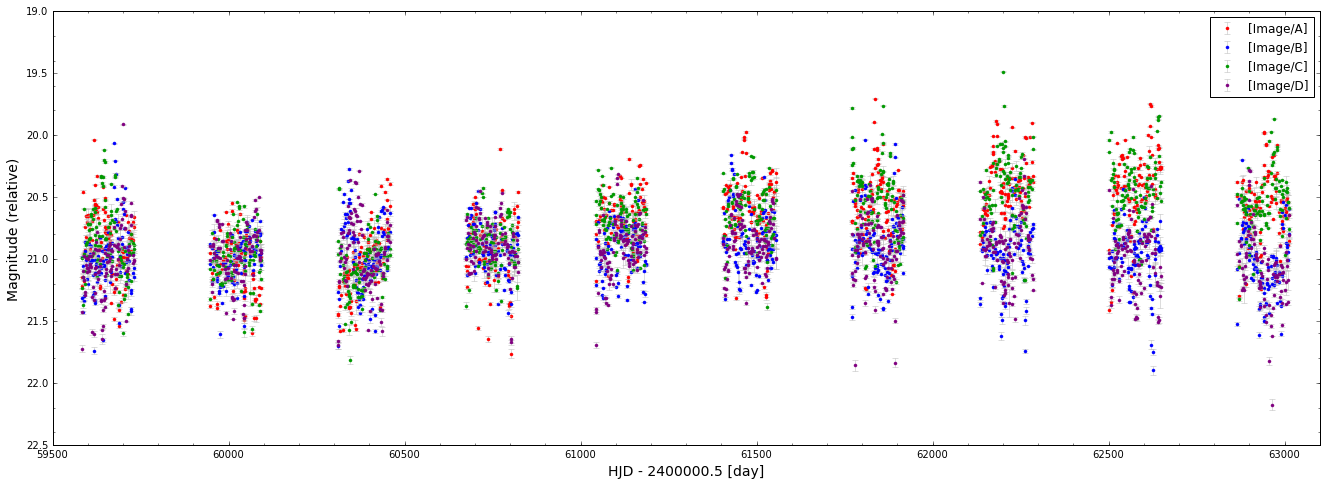

In [4]:
timer.display_light_curves(jdrange=(59500,63100))

These lines will run an entire free-knot spline technique on your data with a complete error analysis using the `TDC2` method. Below, you can specify how the time delays will be analyzed. The default is listed below according to the `PyCS` tutorial. See the bottom of the page for alternate methods. 

In [5]:
timer.estimate_time_delays(method='pycs',microlensing='spline',agn='spline',error=None)

You are using the pycs method.
Starting opt_rough on initial delays :
AB   +0.00 | AC   +0.00 | AD   +0.00 | BC   +0.00 | BD   +0.00 | CD   +0.00
Aiming at first curve.
Starting ML optimization ...
Working on the spline ML of [Image/A]|~3/u/21~|
Working on the spline ML of [Image/B](0.000,-0.257,0)|~3/u/21~|
Working on the spline ML of [Image/C](0.000,-0.015,0)|~3/u/21~|
Working on the spline ML of [Image/D](0.000,-0.253,0)|~3/u/21~|
Done !
First spline and ML opt done.
AB   +7.00 | AC   +2.00 | AD   +1.00 | BC   -5.00 | BD   -6.00 | CD   -1.00    (Iteration  1, r2 = 46623501.4)
AB  +10.00 | AC   +3.00 | AD   +2.00 | BC   -7.00 | BD   -8.00 | CD   -1.00    (Iteration  2, r2 = 45910924.9)
AB  +12.00 | AC   +4.00 | AD   +3.00 | BC   -8.00 | BD   -9.00 | CD   -1.00    (Iteration  3, r2 = 45572597.9)
AB  +14.00 | AC   +5.00 | AD   +4.00 | BC   -9.00 | BD  -10.00 | CD   -1.00    (Iteration  4, r2 = 45311691.1)
AB  +16.00 | AC   +6.00 | AD   +5.00 | BC  -10.00 | BD  -11.00 | CD   -1.00    (I

In [6]:
timer.report_time_delays()

Time Delays:
AB  +23.19
AC   +9.32
AD   +1.90
BC  -13.88
BD  -21.29
CD   -7.41


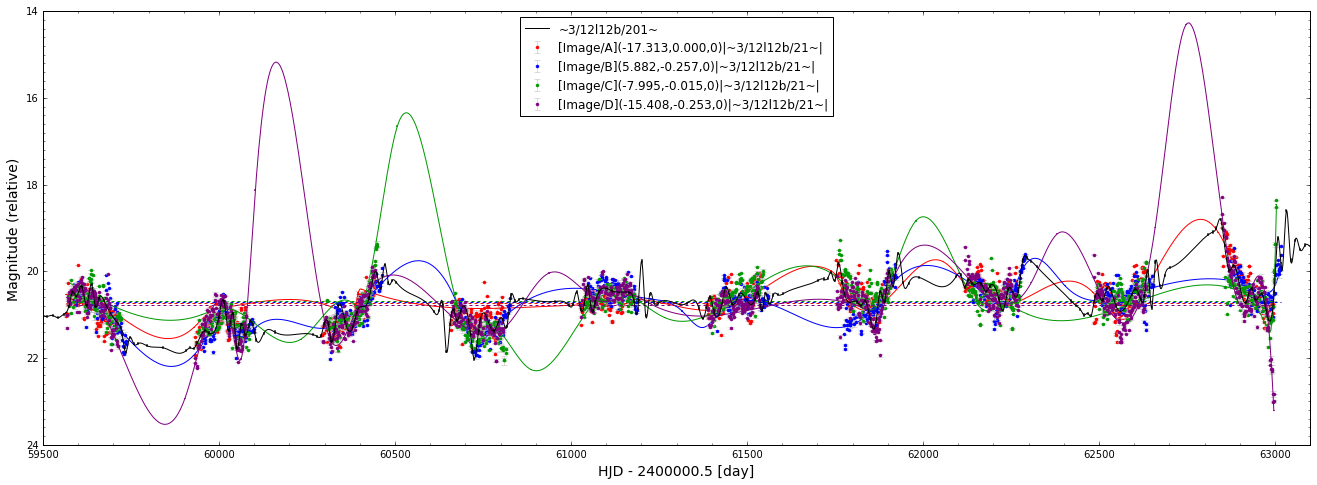

In [7]:
timer.display_light_curves(jdrange=(59500,63100))

In [ ]:
timer.estimate_uncertainties(n=3,npkl=12)

The old files have been deleted.
('Making', 36, 'copies of the original dataset:')
Now thowing dice into sims_copies ...
Input shifts :
A   -17.31 | B    +5.88 | C    -7.99 | D   -15.41
Input delays :
AB  +23.19 | AC   +9.32 | AD   +1.90 | BC  -13.88 | BD  -21.29 | CD   -7.41
Preparing 3 identical copies for pkl 1/12 ...
Wrote sims_copies/1_1468015383.90642.pkl
Preparing 3 identical copies for pkl 2/12 ...
Wrote sims_copies/2_1468015383.99884.pkl
Preparing 3 identical copies for pkl 3/12 ...
Wrote sims_copies/3_1468015384.14819.pkl
Preparing 3 identical copies for pkl 4/12 ...
Wrote sims_copies/4_1468015384.24365.pkl
Preparing 3 identical copies for pkl 5/12 ...
Wrote sims_copies/5_1468015384.32496.pkl
Preparing 3 identical copies for pkl 6/12 ...
Wrote sims_copies/6_1468015384.44297.pkl
Preparing 3 identical copies for pkl 7/12 ...
Wrote sims_copies/7_1468015384.54890.pkl
Preparing 3 identical copies for pkl 8/12 ...
Wrote sims_copies/8_1468015384.62907.pkl
Preparing 3 identical copie

/Users/milanwilliams/PyCS/pycs/gen/spl.py:342: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (self.t == None):


Wrote sims_mocks/1_1468015385.10673.pkl
Drawing 3 simulations for pkl 2/12 ...
Wrote sims_mocks/2_1468015389.51406.pkl
Drawing 3 simulations for pkl 3/12 ...
Wrote sims_mocks/3_1468015394.14148.pkl
Drawing 3 simulations for pkl 4/12 ...
Wrote sims_mocks/4_1468015400.04928.pkl
Drawing 3 simulations for pkl 5/12 ...
Wrote sims_mocks/5_1468015404.34513.pkl
Drawing 3 simulations for pkl 6/12 ...
Wrote sims_mocks/6_1468015408.69505.pkl
Drawing 3 simulations for pkl 7/12 ...
Wrote sims_mocks/7_1468015413.04823.pkl
Drawing 3 simulations for pkl 8/12 ...
Wrote sims_mocks/8_1468015417.44899.pkl
Drawing 3 simulations for pkl 9/12 ...
Wrote sims_mocks/9_1468015421.75532.pkl
Drawing 3 simulations for pkl 10/12 ...
Wrote sims_mocks/10_1468015426.23591.pkl
Drawing 3 simulations for pkl 11/12 ...
Wrote sims_mocks/11_1468015430.39174.pkl
Drawing 3 simulations for pkl 12/12 ...
Wrote sims_mocks/12_1468015434.68484.pkl
I have found 12 simulation pickles in sims_copies.
I'll write my results into the dir